In [1]:
import pandas as pd
import numpy as np
import os
import random
import torch
import torch.nn as nn

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

In [2]:
from ogb.utils.features import (allowable_features, atom_to_feature_vector,
 bond_to_feature_vector, atom_feature_vector_to_dict, bond_feature_vector_to_dict) 
from rdkit import Chem
import numpy as np


def ReorderCanonicalRankAtoms(mol):
    order = tuple(zip(*sorted([(j, i) for i, j in enumerate(Chem.CanonicalRankAtoms(mol))])))[1]
    mol_renum = Chem.RenumberAtoms(mol, order)
    return mol_renum, order

def smiles2graph(smiles_string, removeHs=True, reorder_atoms=False):
    """
    Converts SMILES string to graph Data object
    :input: SMILES string (str)
    :return: graph object
    """

    mol = Chem.MolFromSmiles(smiles_string)
    mol = mol if removeHs else Chem.AddHs(mol)
    if reorder_atoms:
        mol, _ = ReorderCanonicalRankAtoms(mol)

    # atoms
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_to_feature_vector(atom))
    x = np.array(atom_features_list, dtype = np.int64)

    # bonds
    num_bond_features = 3  # bond type, bond stereo, is_conjugated
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # add edges in both directions
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = np.array(edges_list, dtype = np.int64).T

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = np.array(edge_features_list, dtype = np.int64)

    else:   # mol has no bonds
        edge_index = np.empty((2, 0), dtype = np.int64)
        edge_attr = np.empty((0, num_bond_features), dtype = np.int64)

    graph = dict()
    graph['edge_index'] = edge_index
    graph['edge_feat'] = edge_attr
    graph['node_feat'] = x
    graph['num_nodes'] = len(x)

    return graph 


if __name__ == '__main__':
    graph = smiles2graph('O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5')
    print(graph)

{'edge_index': array([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  3,  6,  6,  7,  7,  8,
         8,  9,  9, 10, 10, 11,  9, 12, 12, 13, 13, 14, 14, 15, 15, 16,
        15, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22,  4,  0,  7,  5,
        13,  6, 18, 12, 21, 17],
       [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  3,  7,  6,  8,  7,
         9,  8, 10,  9, 11, 10, 12,  9, 13, 12, 14, 13, 15, 14, 16, 15,
        17, 15, 18, 17, 19, 18, 20, 19, 21, 20, 22, 21,  0,  4,  5,  7,
         6, 13, 12, 18, 17, 21]]), 'edge_feat': array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
    

In [7]:
import pandas as pd
import numpy as np
from ogb.utils.features import atom_to_feature_vector, bond_to_feature_vector
from rdkit import Chem
from datasets import DatasetDict

def ReorderCanonicalRankAtoms(mol):
    order = tuple(zip(*sorted([(j, i) for i, j in enumerate(Chem.CanonicalRankAtoms(mol))])))[1]
    mol_renum = Chem.RenumberAtoms(mol, order)
    return mol_renum, order

def smiles2graph(smiles_string, removeHs=True, reorder_atoms=False):
    """
    Converts SMILES string to graph Data object
    :input: SMILES string (str)
    :return: graph object
    """
    mol = Chem.MolFromSmiles(smiles_string)
    mol = mol if removeHs else Chem.AddHs(mol)
    if reorder_atoms:
        mol, _ = ReorderCanonicalRankAtoms(mol)

    # atoms
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_to_feature_vector(atom))
    x = np.array(atom_features_list, dtype=np.int64)

    # bonds
    num_bond_features = 3  # bond type, bond stereo, is_conjugated
    if len(mol.GetBonds()) > 0:  # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # add edges in both directions
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = np.array(edges_list, dtype=np.int64).T

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = np.array(edge_features_list, dtype=np.int64)

    else:  # mol has no bonds
        edge_index = np.empty((2, 0), dtype=np.int64)
        edge_attr = np.empty((0, num_bond_features), dtype=np.int64)

    graph = dict()
    graph['edge_index'] = edge_index
    graph['edge_feat'] = edge_attr
    graph['node_feat'] = x
    graph['num_nodes'] = len(x)

    return graph

def process_csv_to_graphs(csv_path):
    # Read CSV file
    df = pd.read_csv(csv_path)

    # Initialize lists to store graph data and labels
    graphs = []
    labels = []

    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        smiles = row['Smiles']
        pIC50 = row['pIC50']

        # Convert SMILES to graph
        graph = smiles2graph(smiles)

        # Append the graph and pIC50 as label
        graphs.append({
            'edge_index': graph['edge_index'],
            'edge_attr': graph['edge_feat'],
            'node_feat': graph['node_feat'],
            'num_nodes': graph['num_nodes'],
        })

        # Append the pIC50 value as the label
        labels.append([pIC50])

    # Convert to DatasetDict format
    dataset = DatasetDict({
        'train': {
            'edge_index': [g['edge_index'] for g in graphs],
            'edge_attr': [g['edge_attr'] for g in graphs],
            'node_feat': [g['node_feat'] for g in graphs],
            'num_nodes': [g['num_nodes'] for g in graphs],
            'y': labels
        }
    })

    return dataset


# Specify the path to the train.csv file
csv_path = '../dataset/train.csv'

# Process the CSV file and convert to graph format
dataset = process_csv_to_graphs(csv_path)

# Print out the dataset structure
# print(dataset['train'][:10])

TypeError: unhashable type: 'slice'

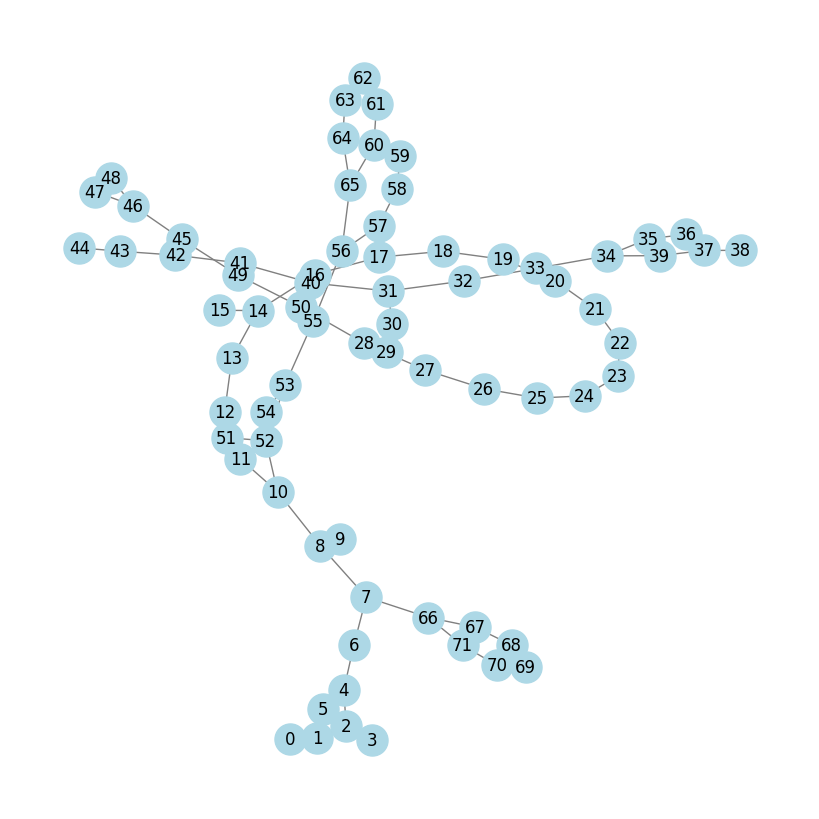

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Access the 'train' split
train_split = dataset['train']

# Extract the first graph's edge_index, edge_attr, node_feat, and num_nodes
edges = train_split['edge_index'][0]  # First graph's edge index
num_nodes = train_split['num_nodes'][0]  # First graph's number of nodes

# Create a networkx graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(range(num_nodes))

# Add edges (from edge_index)
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(edges.shape[1])])

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.show()


In [5]:
from transformers.models.graphormer import GraphormerConfig, GraphormerModel
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

# dataset_processed = dataset.map(preprocess_item, batched=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GraphormerModel(GraphormerConfig())
model.to(device)

for train_data in dataset['train']:
    # train_data = preprocess_item(train_data)
    model(
        input_nodes=train_data.input_nodes
    )

/Users/taewonkim/Develop/Python/Dacon2408Medic/.venv/lib/python3.10/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/taewonkim/Develop/Python/Dacon2408Medic/.venv/lib/python3.10/site-packages/transformers/models/graphormer/algos_graphormer.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /Users/taewonkim/.pyxbld/temp.macosx-10.9-universal2-cpython-310/Users/taewonkim/Develop/Python/Dacon2408Medic/.venv/lib/python3.10/site-packages/transformers/models/graphormer/algos_graphormer.c:1240:
In file included from /Users/taewonkim/Develop/Python/Dacon2408Medic/.venv/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/taewonkim/Develop/Python/Dacon2408Medic/.venv/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/taewonkim/Develop/Pytho

AttributeError: 'str' object has no attribute 'keys'